In [1]:
using Polynomials, PyPlot, Interact

# Eigenvalues: The Key Idea

If we can find a solution $x \ne 0$ to

$$
Ax = \lambda x
$$

then, for this vector, the matrix $A$ **acts like a scalar**.  $x$ is called an **eigenvector** of $A$, and $\lambda$ is called an **eigenvalue**.

In fact, for an $m \times m$ matrix $A$, we typically find $m$ linearly independendent eigenvectors $x_1,x_2,\ldots,x_m$ and $m$ corresponding eigenvalues $\lambda_1, \lambda_2, \ldots, \lambda_m$.   Such a matrix is called **diagonalizable**.  Most matrices are diagonalizable; we will deal with the rare "defective" (non-diagonalizable) case later.

Given such a **basis of eigenvectors**, the key idea for using them is:

1. Take any vector $x$ and expand it in this basis: $x = c_1 x_1 + \cdots c_m x_n$, or $x = Xc$ or $c = X^{-1}x$ where $X$ is the matrix whose *columns are the eigenvectors*.

2. For each eigenvector $x_k$, the matrix $A$ acts like a scalar $\lambda_k$.  Multiplication or division corresponds to multiplying/dividing $x_k$ by $\lambda_k$.  **Solve your problem for each eigenvector by treating A as the scalar λ**.

3. Add up the solution to your problem (sum the basis of the eigenvectors).  That is, multiply the new coefficients by $X$.

# The characteristic polynomial

To *find* the eigenvalues, one approach is to realize that $Ax = \lambda x$ means:

$$
(A - \lambda I) x = 0 \, ,
$$

so the matrix $A - \lambda I$ is **singular for any eigenvalue λ**.  This corresponds to the determinant being zero:

$$
p(\lambda) = \det(A - \lambda I) = 0
$$

where $p(\lambda)$ is the **characteristic polynomial of A: a polynomial of degree m** if $A$ is $m \times m$.  The **roots of this polynomial are the eigenvalues λ**.

A polynomial of degree $m$ has at most $m$ roots (possibly complex), and typically has $m$ distinct roots.  **This is why most matrices have $m$ distinct eigenvalues/eigenvectors**, and are therefore **diagonalizable**.

For example, let's plot the $\det(A - \lambda I)$ for a 4×4 matrix $A$.  The result is a *quartic* curve whose roots are the four eigenvalues (computed by the built-in `eigvals` function):

In [2]:
# some "random" matrix:
A = [ 0.325  -0.075   0.075  -0.075
      0.025   0.225  -0.025  -0.275
       0.15   -0.05    0.25   -0.05 
       -0.1    -0.1     0.1     0.4  ]

λ = eigvals(A)

4-element Array{Float64,1}:
 0.1
 0.2
 0.4
 0.5

(I admit it: $A$ was not chosen at random to have such special eigenvalues.)

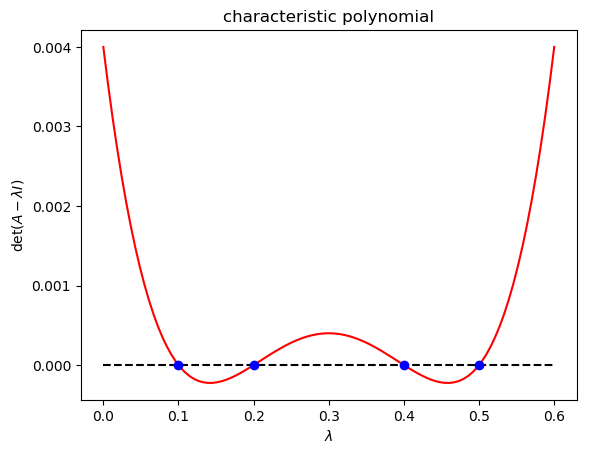

PyObject Text(0.5,1,u'characteristic polynomial')

In [3]:
ξ = linspace(0,0.6,100)
plot(ξ, [det(A - λ*I) for λ in ξ], "r-")
plot(ξ, zeros(ξ), "k--")
plot(λ, zeros(λ), "bo")
xlabel(L"\lambda")
ylabel(L"\det(A - \lambda I)")
title("characteristic polynomial")

## Eigenvalue example:

For example, consider the matrix

$$
A = \begin{pmatrix} 1 & 1 \\ -2 & 4 \end{pmatrix}
$$

whose eigenvalues are $\lambda = \{2,3\}$:

In [4]:
A = [ 1 1
     -2 4 ]

2×2 Array{Int64,2}:
  1  1
 -2  4

In [5]:
eigvals(A)

2-element Array{Float64,1}:
 2.0
 3.0

The characteristic polynomial is

$$
\det(A - \lambda I) = \det \begin{pmatrix} 1 - \lambda & 1 \\ -2 & 4 - \lambda \end{pmatrix} = (1 - \lambda)(4 - \lambda) - (1)(-2) = \lambda^2 - 5\lambda + 6 = (\lambda - 2) (\lambda - 3)
$$

where we have used high-school algebra to factor the polynomial.   Hence its roots are $\lambda = \{2, 3\}$, as computed above.

## Eigenvectors

Once we have the eigenvalues, finding the eigenvectors is (in principle) easy: **the eigenvectors are just (a basis for) the nullspace**

$$
N(A - \lambda I)
$$

when $\lambda$ is an eigenvalue.

For example, with the matrix above, let's take the eigenvalue $\lambda_1 = 2$:

$$
A - 2I = \begin{pmatrix} -1 & 1 \\ -2 & 2 \end{pmatrix}
$$

We could go through Gaussian elimination to find the nullspace, but we can see by inspection that the second column is minus the first, hence $x_1 = (1, 1)$ is a basis for the nullspace:

$$
(A - 2I) x_1 = \begin{pmatrix} -1 & 1 \\ -2 & 2 \end{pmatrix} \begin{pmatrix} 1 \\ 1 \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \end{pmatrix}
$$

or

$$
A x_1 = 2 x_1
$$

as desired.  $x_1 = (1, 1)$ is an eigenvector!  Let's check:

In [6]:
A * [1, 1]

2-element Array{Int64,1}:
 2
 2

For the other eigenvalue, $\lambda = 3$, we get:

$$
A - 3I = \begin{pmatrix} -2 & 1 \\ -2 & 1 \end{pmatrix}
$$

from which it is obvious that a basis for the nullspace is $x_2 = (1, 2)$.  Let's check:

In [7]:
A * [1, 2]

2-element Array{Int64,1}:
 3
 6

Yup, $A x_2 = 3 x_2$!

For more complicated cases, of course, we might have to go through elimination to find the nullspace.  In practice, though, we alway just let the computer do it.  The `eig` function in Julia will return the eigenvalues and eigenvectors:

In [8]:
λ, X = eig(A)

([2.0, 3.0], [-0.707107 -0.447214; -0.707107 -0.894427])

In [9]:
λ

2-element Array{Float64,1}:
 2.0
 3.0

In [10]:
X

2×2 Array{Float64,2}:
 -0.707107  -0.447214
 -0.707107  -0.894427

The columns of `X` are indeed the eigenvectors from above, but they are scaled differently (they are normalized to unit length).  If we divide each one by its first element, though, we should recover our scaling from above:

In [11]:
X[:,1] / X[1,1]  # first column, with first entry scaled to 1

2-element Array{Float64,1}:
 1.0
 1.0

In [12]:
X[:,2] / X[1,2] # second column, with second entry scaled to 1

2-element Array{Float64,1}:
 1.0
 2.0

In practice, computing eigenvalues by hand, especially by this method, is even more pointless than doing Gaussian elimination by hand, for reasons explained below, so I will **focus more on the properties of eigenvalues and how to use them than how to compute them.**  The computer will give us their values.

## Transpose: Same eigenvalues!

One of the properties of determinant is that $\det A^T = \det A$.   It follows that
$$\det(A-\lambda I) = \det\left[ (A -\lambda I)^T \right] = \det (A^T - \lambda I)$$
and therefore $A$ and $A^T$ have the **same eigenvalues!**  (They have the **same characteristic polynomial**.)

Let's check:

In [13]:
eigvals(A')

2-element Array{Float64,1}:
 2.0
 3.0

Yup, same eigenvalues (2 and 3) as for $A$.

However, $A$ and $A^T$ in general have **different eigenvectors**, because the **left and right nullspaces are not usually the same**.  $N(A - \lambda I) \ne N(A^T - \lambda I)$ in general.  Here, the eigenvectors are:

In [14]:
Y = eigvecs(A')
Y ./ Y[1,:]' # normalize so that the first components are 1, for easier comparison

2×2 Array{Float64,2}:
  1.0   1.0
 -0.5  -1.0

Notice that these are different from the (1,1) and (1,2) that we got above.

As you might guess, the eigenvectors of $A^T$ are sometimes called its **left eigenvectors**.

## Complex eigenvalues

If we change the matrix to:
$$
\begin{pmatrix} 1 & 3 \\ -2 & 4 \end{pmatrix}
$$
we get a characteristic polynomial:
$$
\det \begin{pmatrix} 1 - \lambda & 3 \\ -2 & 4 - \lambda \end{pmatrix} = (1 - \lambda)(4 - \lambda) - (3)(-2) = \lambda^2 - 5\lambda + 10
$$
whose roots, from the quadratic formula, are:
$$
\lambda = \frac{5 \pm \sqrt{5^2 - 40}}{2} = \frac{5 \pm \sqrt{-15}}{2}
$$
which are complex!  Let's check:

In [15]:
eigvals([1 3
        -2 4])

2-element Array{Complex{Float64},1}:
 2.5+1.93649im
 2.5-1.93649im

In [16]:
(5 + sqrt(15)*im) / 2

2.5 + 1.9364916731037085im

Yup, it matches our formula.

**Eigenvalues may be complex numbers, even for real matrices**.  We can't avoid complex numbers for any longer in 18.06!

(But, for real matrices, they are the [roots of a real polynomial](https://en.wikipedia.org/wiki/Complex_conjugate_root_theorem) and hence come in [complex conjugate pairs](https://en.wikipedia.org/wiki/Complex_conjugate).)

# The perils of polynomial roots

You might think that finding roots of polynomials is we must inevitably find eigenvalues.  In fact, although we use the characteristic polynomial to *think* about eigenvalues, in practice they are not used to *compute* them except for tiny matrices.

In fact, working with the characteristic polynomial is a computational disaster in general, because **roots of polynomials are exponentially sensitive to their coefficients**.  Any tiny roundoff error leads to disaster.

For example, consider the polynomial

$$
w(x) = (x - 1) (x - 2) (x - 3) \cdots (x - 10)
$$
whose roots are, obviously, ${1,2,\ldots,10}$.  What happens if we actually multiply this polynomial together and compute the roots from the coefficients?

In [17]:
w = prod([Poly([-n, 1.0]) for n = 1:10])

Poly(3.6288e6 - 1.062864e7*x + 1.2753576e7*x^2 - 8.4095e6*x^3 + 3.41693e6*x^4 - 902055.0*x^5 + 157773.0*x^6 - 18150.0*x^7 + 1320.0*x^8 - 55.0*x^9 + 1.0*x^10)

Already, this seems hard: how do we find roots of a high-degree polynomial?  More on this below.

For the moment, we will just use a "black box" function `roots` provided by the Polynomials package to "magically" get the roots of $w$ from its coefficients:

In [18]:
roots(w)

10-element Array{Float64,1}:
 10.0
  9.0
  8.0
  7.0
  6.0
  5.0
  4.0
  3.0
  2.0
  1.0

Looks good!  The roots are what they should be.

Howevever, suppose we make a *tiny error* in computing the coefficients.  Let's multiply each coefficient by $1 + \epsilon$, where $\epsilon$ is a *random small number* of root-mean-square value $R$.

The following code plots the roots in the [complex plane](https://en.wikipedia.org/wiki/Complex_plane) for 100 random perturbations, and lets us vary the magnitude $R$ of the pertubation:

Interact.Options{:SelectionSlider,Any}(1: "input" = -6.5 Any , "logR", -6.5, "-6.5", 56, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("-12.0"=>-12.0,"-11.9"=>-11.9,"-11.8"=>-11.8,"-11.7"=>-11.7,"-11.6"=>-11.6,"-11.5"=>-11.5,"-11.4"=>-11.4,"-11.3"=>-11.3,"-11.2"=>-11.2,"-11.1"=>-11.1…), Dict{Any,Any}(Pair{Any,Any}(-6.3, "-6.3"),Pair{Any,Any}(-2.3, "-2.3"),Pair{Any,Any}(-7.0, "-7.0"),Pair{Any,Any}(-1.3, "-1.3"),Pair{Any,Any}(-8.3, "-8.3"),Pair{Any,Any}(-9.1, "-9.1"),Pair{Any,Any}(-3.4, "-3.4"),Pair{Any,Any}(-10.1, "-10.1"),Pair{Any,Any}(-8.2, "-8.2"),Pair{Any,Any}(-3.0, "-3.0")…)), Any[], Any[], true, "horizontal")

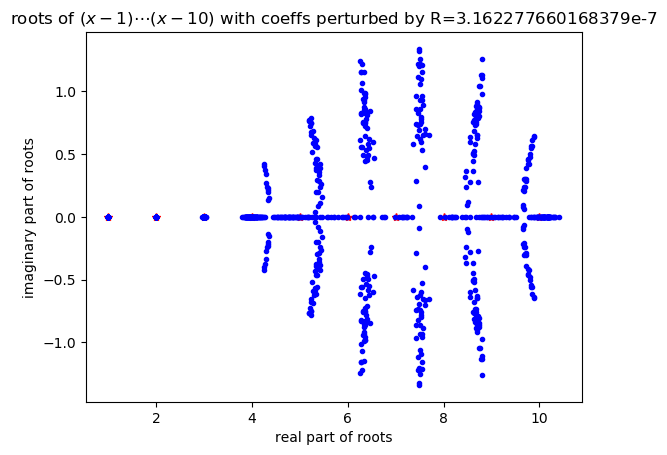

In [19]:
N = 10
w = prod([Poly([-n, 1.0]) for n = 1:N])
fig = figure()
@manipulate for logR in -12:0.1:-1
    withfig(fig) do
        plot(1:N, zeros(10), "r*")
        R = exp10(logR)
        for i = 1:100
            r = roots(Poly(coeffs(w) .* (1 .+ R .* randn(N+1))))
            plot(real(r), imag(r), "b.")
        end
        xlabel("real part of roots")
        ylabel("imaginary part of roots")
        title("roots of \$(x-1)\\cdots(x-10)\$ with coeffs perturbed by R=$R")
    end
end

Even a **tiny error** causes the roots to be **complete garbage**.  This gets exponentially worse as the degree of the polynomials increases.

Because computers inevitably use a finite precision (usually about 15 significant digits), the tiny roundoff errors mean that characteristic polynomials are a computational disaster if they are actually computed explicitly.

# Companion matrices

Finding **roots of polynomials is *equivalent* to finding eigenvalues**.  Not only can you find eigenvalues by solving for the roots of the characteristic polynomial, but you can conversely find roots of *any* polynomial by turning into a matrix and finding the eigenvalues.

Given the degree-$n$ polynomial:

$$
p(z)=c_0 + c_1 z + \cdots + c_{n-1}z^{n-1} + z^n \;,
$$

(notice that the $z^n$ coefficient is 1), we define the $n \times n$  **companion matrix**

$$
C=\begin{pmatrix}
0 & 1 & 0 & \dots & 0 \\
0 & 0 & 1 & \dots & 0 \\
0 & \ddots & \ddots & \ddots & \vdots \\
\vdots & \vdots & \ddots & 0 & 1 \\
-c_0 & -c_1 & \dots & -c_{n-2} & -c_{n-1}
\end{pmatrix}.
$$

The amazing fact is that the *characteristic polynomial* $\det (C - \lambda I) = p(\lambda)$, and so the **eigenvalues of C are the roots of p**.

## Proof

Suppose $z$ is an root of $p(z) = 0$.  We can now show that this is an eigenvalue of $C$, with eigenvector $= (1,z,z^2,\ldots,z^{n-1})$:

$$
C \begin{pmatrix} 1 \\ z \\ z^2 \\ \vdots \\ z^{n-1} \end{pmatrix}
= \begin{pmatrix} z \\ z^2 \\ \vdots \\ z^{n-1} \\ -c_0 - c_1 z - \cdots - c_{n-1} z^{m-1} \end{pmatrix}
= \begin{pmatrix} z \\ z^2 \\ \vdots \\ z^{n-1} \\ z^n \end{pmatrix}
= z \begin{pmatrix} 1 \\ z \\ z^2 \\ \vdots \\ z^{n-1} \end{pmatrix}
$$

where in the last row we used the fact that $p(z) = 0$ so $z^n = -c_0 - c_1 z - \cdots - c_{n-1} z^{m-1}$.

Hence $z$ is an eigenvalue.  The **eigenvalues of C are the roots of p** and vice versa.

## Conclusion

If you have a polynomial whose leading coefficient is *not* 1, you can just divide the polynomial by that coefficient to get it in this form, without changing its roots.   Hence the **roots of any polynomial can be found by computing the eigenvalues of a companion matrix.**

In [20]:
function companion(p::Poly)
    c = coeffs(p)
    n = degree(p)
    c = c[1:n] / c[end]
    C = [ [ zeros(n-1)'; eye(n-1,n-1) ] -c ]'
    return C
end

companion (generic function with 1 method)

In [21]:
p = Poly([-2, 1]) * Poly([-3, 1]) # (x - 2) * (x - 3)

Poly(6 - 5*x + x^2)

In [22]:
C = companion(p)

2×2 Array{Float64,2}:
  0.0  1.0
 -6.0  5.0

In [23]:
eigvals(C)

2-element Array{Float64,1}:
 2.0
 3.0

In [24]:
 # (x - 2) * (x - 3) * (x - 4) * (x + 1)
p = Poly([-2, 1]) * Poly([-3, 1]) * Poly([-4, 1]) * Poly([1, 1])

Poly(-24 + 2*x + 17*x^2 - 8*x^3 + x^4)

In [25]:
C = companion(p)

4×4 Array{Float64,2}:
  0.0   1.0    0.0  0.0
  0.0   0.0    1.0  0.0
  0.0   0.0    0.0  1.0
 24.0  -2.0  -17.0  8.0

In [26]:
eigvals(C)

4-element Array{Float64,1}:
 -1.0
  4.0
  3.0
  2.0

In fact, **this is the most common method to find roots of polynomials of degree ≥ 5**: you find the companion matrix, and compute its eigenvalues.  This is precisely how the Polynomials package does it (albeit with some extra cleverness to check for leading and trailing zero coefficients):

In [27]:
@which roots(p)

roots(p::Polynomials.Poly{T}) where T in Polynomials at /Users/stevenj/.julia/v0.6/Polynomials/src/Polynomials.jl:625

This would seem rather circular if eigenvalues were computed, in turn, by finding roots of polynomials.  But they aren't: **practical computer eigenvalue solvers never compute the characteristic polynomial, and don't resemble generic root-finding algorithms (like Newton's method)**.

# Computing eigenvalues = polynomial roots = hard

* Everyone learns the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula) to find roots of a quadratic (degree-2) polynomial.

* There is a (horrible) [cubic formula](https://en.wikipedia.org/wiki/Cubic_function) to find the roots of any cubic (degree-3) polynomial.

* There is a (terrifying) [quartic formula](https://en.wikipedia.org/wiki/Quartic_function) to find the roots of any quartic (degree-4) polynomial.

* There is **no formula** (in terms of a *finite number* of ±,×,÷,ⁿ√) for the roots of an **arbitrary quintic** polynomial or **any degree ≥ 5**.  This is the [Abel–Ruffini theorem](https://en.wikipedia.org/wiki/Abel%E2%80%93Ruffini_theorem), proved in the 19th century.

This does **not mean** that you can't compute roots (or eigenvalues) in practice!  But it means that **root-finding/eigenvalue algorithms are necessarily *iterative***: they **converge toward the solution** but **never reach it exactly**.  You can get the solution to *any desired accuracy*.

For example we've already seen one such algorithm!  [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) is an algorithm that could be used to find the roots of an arbitrary polynomial (given enough starting guesses), and converges *very* quickly without ever exactly *reaching* the root.

The most common algorithm to find eigenvalues (and hence polynomial roots, via companion matrices) is the [QR algorithm](https://en.wikipedia.org/wiki/QR_algorithm).  As you might guess, it is *related* to the $A=QR$ factorization.  Explaining *how* and *why* this algorithm works, however, is outside the scope of 18.06.  (It takes me a week+ in 18.335: graduate numerical methods.)

This means that the textbook characteristic-polynomial method we use to find eigenvalues of $2\times 2$ matrices is something of a fraud: unlike Gaussian elimination, it bears no resemblance whatsoever to how eigenvalues are really computed.  In 18.06, therefore, we will mostly assume that the computer hands us the eigenvalues and eigenvectors, and **we will focus on what eigensolutions *mean*, how they are *used*, and what their *properties* are.**

One thing that it is useful to know, however, is that the computer algorithm to compute eigenvalues/eigenvectors of an $m \times m$ matrix requires $\sim m^3$ operations, just like Gaussian elimination.  However, the "constant"  coefficient in front of $m^3$ is significantly worse:

In [28]:
A1000 = rand(1000,1000)
@time lufact(A1000)
@time qrfact(A1000)
@time eigvals(A1000)
@time eig(A1000);

  0.031349 seconds (108 allocations: 7.645 MiB, 31.78% gc time)
  0.138573 seconds (18.95 k allocations: 9.236 MiB)
  1.471903 seconds (25 allocations: 7.936 MiB, 2.33% gc time)
  2.999452 seconds (6.44 k allocations: 31.167 MiB, 2.77% gc time)


In [29]:
@elapsed(eig(A1000)) / @elapsed(lufact(A1000))

89.20126901351644

Finding eigenvalues and/or eigenvectors is not so cheap, but it is often worth it!